In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1 Collaborative Filtering

##### Use this user-item matrix to:

##### A. Recommend 10 songs to users who have listened to 'u2' and 'pink floyd'. Use item-item collaborative filtering to find songs that are similar using spatial distance with cosine.

In [2]:
radio_songs = pd.read_csv ('radio_songs.csv', index_col='user')
radio_songs.shape

(100, 284)

In [3]:
radio_songs.sample(3)

,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,...,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
user,,,,,,,,,,,,,,,,,,,,,
852,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can use the <b>pdist and squareform functions</b> to compute the similarity between all pairs of items in a user-item matrix to obtain a similarity matrix in one go

In [4]:
from scipy.spatial.distance import pdist, squareform

# Get the transpose of the user-item matrix
item_user_matrix = radio_songs.T

# Compute the pairwise cosine similarity between items
item_similarity_matrix = 1 - squareform(pdist(item_user_matrix, metric='cosine'))

# Convert the similarity matrix to a DataFrame
item_similarity_df = pd.DataFrame(item_similarity_matrix, columns=radio_songs.columns, index=radio_songs.columns)

u2_pinkfloyd = item_similarity_df[['u2','pink floyd']]

# Filter the DataFrame to include only rows with non-zero values for 'u2' and 'pink floyd'
filtered_df = u2_pinkfloyd.loc[(u2_pinkfloyd['u2'] > 0) | (u2_pinkfloyd['pink floyd'] > 0)].copy()

# Create a new column that sums the values of 'u2' and 'pink floyd' using .loc to avoid warning message
filtered_df.loc[:, 'combined_score'] = filtered_df['u2'] + filtered_df['pink floyd']

# Sort the DataFrame by the 'combined_score' column in descending order, excluding 'u2' and 'pink floyd'
sorted_df = filtered_df.drop(['u2', 'pink floyd']).sort_values(by='combined_score', ascending=False)

# Create a boolean mask for entries where both the 'u2' and 'pink floyd' are not zero
both_non_zero_mask = (sorted_df['u2'] != 0) & (sorted_df['pink floyd'] != 0)

# Create a boolean mask for entries where at least one of the 'u2' or 'pink floyd' is zero
at_least_one_zero_mask = ~both_non_zero_mask

# Sort the DataFrame by the 'combined_score' column in descending order, excluding 'u2' and 'pink floyd'
sorted_df = sorted_df.loc[both_non_zero_mask].sort_values(by='combined_score', ascending=False).append(
            sorted_df.loc[at_least_one_zero_mask].sort_values(by='combined_score', ascending=False))


# Get the top 10 artists based on the combined score, excluding 'u2' and 'pink floyd'
top_artists = sorted_df.index[:10].tolist()

# Print the top 10 artists
print(f"The recommended top 10 songs for users who have listened to 'u2' AND 'pink floyd' :\n")
print(top_artists)


The recommended top 10 songs for users who have listened to 'u2' AND 'pink floyd' :

['robbie williams', 'johnny cash', 'audioslave', 'foo fighters', 'pearl jam', 'incubus', 'genesis', 'misfits', 'green day', 'depeche mode']


In [5]:
sorted_df.head(10)

,u2,pink floyd,combined_score
robbie williams,0.500000,0.288675,0.788675
johnny cash,0.353553,0.204124,0.557678
audioslave,0.223607,0.258199,0.481806
foo fighters,0.301511,0.174078,0.475589
pearl jam,0.204124,0.235702,0.439826
incubus,0.144338,0.166667,0.311004
genesis,0.000000,0.577350,0.577350
misfits,0.500000,0.000000,0.500000
green day,0.433013,0.000000,0.433013
depeche mode,0.408248,0.000000,0.408248


##### Based on combined scores (calculated for users who have listened to u2 OR pink floyd)

['robbie williams', 'genesis', 'johnny cash', 'misfits', 'audioslave', 'foo fighters', 'pearl jam', 'green day', 'depeche mode', 'hans zimmer']


                           u2	        pink floyd	 combined_score
    robbie williams	    0.500000	  0.288675	   0.788675
    genesis	            0.000000	  0.577350	   0.577350
    johnny cash	        0.353553	  0.204124	   0.557678
    misfits	            0.500000	  0.000000	   0.500000
    audioslave	         0.223607	  0.258199	   0.481806
    foo fighters	       0.301511	  0.174078	   0.475589
    pearl jam	          0.204124	  0.235702	   0.439826
    green day	          0.433013	  0.000000	   0.433013
    depeche mode	       0.408248	  0.000000	   0.408248
    hans zimmer	        0.000000	  0.408248	   0.408248

##### B. Find user most similar to user 1606. Use user-user collaborative filtering with cosine similarity. List the recommended songs for user 1606 (Hint: find the songs listened to by the most similar user).



In [6]:
# Compute the pairwise cosine similarity between users
user_similarity_matrix = 1 - squareform(pdist(radio_songs, metric='cosine'))

# Convert the similarity matrix to a DataFrame
user_similarity_df = pd.DataFrame(user_similarity_matrix, columns=radio_songs.index, index=radio_songs.index)

# Find the user most similar to user 1606
most_similar_user = user_similarity_df[1606].drop(1606).idxmax()

print(f"The user most similar to user 1606 is user {most_similar_user}.")


The user most similar to user 1606 is user 1144.


Going with the assumption that we would not want to recommend songs that 1606 has already listened to

In [7]:
# Find the songs listened to by the most similar user
most_similar_user_songs = radio_songs.loc[most_similar_user, radio_songs.loc[most_similar_user] == 1].index

# Find the songs that the target user (1606) has not listened to
target_user_unheard_songs = radio_songs.loc[1606, radio_songs.loc[1606] == 0].index

# Find the intersection of the two sets of songs
recommended_songs = most_similar_user_songs.intersection(target_user_unheard_songs).tolist()

print(f"The recommended songs for user 1606 based on most similar user {most_similar_user} are :\n")
print(recommended_songs)


The recommended songs for user 1606 based on most similar user 1144 are :

['beastie boys', 'bob dylan', 'bob marley & the wailers', 'david bowie', 'eric clapton', 'johnny cash', 'pearl jam', 'pink floyd', 'the doors', 'the rolling stones', 'tom waits']


##### C. How many of the recommended songs has already been listened to by user 1606?

In [8]:
print(f"The number of recommended songs already listened to by user 1606 is : \
{len(most_similar_user_songs) - len(recommended_songs)} \n\nThey are :")

print(set(most_similar_user_songs) ^ set(recommended_songs))

The number of recommended songs already listened to by user 1606 is : 2 

They are :
{'elvis presley', 'the beatles'}


##### D. Use a combination of user-item approach to build a recommendation score for each song for each user using the following steps for each user

This code iterates over each user and each song for the user, and for each song, it gets the top 10 similar songs and their similarity scores. It then gets a list of purchases for each of the top 10 similar songs, and calculates a recommendation score for the song based on the purchase history and similarity scores. Finally, it updates the recommendation scores DataFrame with the calculated recommendation score for each song for each user.

To get the top 5 song recommendations for user 1606, we simply filter the recommendation scores DataFrame for user 1606 and get the top 5 songs with the highest recommendation scores. These are the songs that are most likely to be of interest to user 1606 based on their purchase history and the purchase history of users who have similar preferences.

In [9]:
# Compute the pairwise cosine similarity between items
item_similarity_matrix = 1 - squareform(pdist(radio_songs.T, metric='cosine'))

# Convert the similarity matrix to a DataFrame
item_similarity_df = pd.DataFrame(item_similarity_matrix, columns=radio_songs.columns, index=radio_songs.columns)

# Initialize an empty DataFrame to store the recommendation scores
recommendation_scores_df = pd.DataFrame(columns=radio_songs.columns, index=radio_songs.index)

# Iterate over each user
for user in radio_songs.index:
    # Iterate over each song for the user
    for song in radio_songs.columns:
        # Get the top 10 similar songs and their similarity score
        top_10_similar_songs = item_similarity_df[song].drop(song).nlargest(10)
        
        # Get a list of purchases for each of the top 10 similar songs
        purchase_history = []
        for similar_song, similarity_score in top_10_similar_songs.iteritems():
            if radio_songs.loc[user, similar_song] == 1:
                purchase_history.append(similarity_score)
        
        # Calculate the recommendation score for the song
        if len(purchase_history) > 0:
            recommendation_score = sum(purchase_history) / sum(top_10_similar_songs)
        else:
            recommendation_score = 0
        
        # Update the recommendation scores DataFrame
        recommendation_scores_df.loc[user, song] = recommendation_score

    
# Convert the recommendation scores DataFrame to a numeric data type
recommendation_scores_df = recommendation_scores_df.apply(pd.to_numeric)

# Print the top 5 song recommendations for user 1606
top_recommendations = recommendation_scores_df.loc[1606].nlargest(5)
print(f"The top 5 song recommendations for user 1606 are:")
for song, score in top_recommendations.iteritems():
    print(f"{song} (score: {score})")

The top 5 song recommendations for user 1606 are:
elvis presley (score: 0.2893278354309895)
abba (score: 0.23902308185961815)
eric clapton (score: 0.20274011674755033)
frank sinatra (score: 0.2011393381145825)
howard shore (score: 0.17174865637166106)


## 2 Conceptual questions

<i>1. Name 2 other similarity measures that you can use instead of cosine similarity above.</i>

Two commonly used similarity measures that can be used instead of cosine similarity are 
* a. Euclidean distance
* b. Pearson correlation coefficient

<br>

<i>2. What is needed to build a Content-Based Recommender system?</i>

Content-based filtering uses similarities in products, services, or content features, as well as information accumulated about the user to make recommendations. A content based recommender works with data that the user provides, either explicitly (rating) or implicitly (clicking on a link). Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

Building a Content-Based Recommender System involves the following steps :
* <b>Defining user profile based on their past interactions or preferences with the items.</b> This can include the items they have previously rated or interacted with.
* <b>Computing the similarity between the user profile and the available items.</b> This can be done using a similarity measure such as cosine similarity.
* <b>Ranking the recommendations based on their similarity score, and recommend the top items to the user.</b>

<br>

<i>3. Name 2 methods to evaluate your recommender system.</i>

<b>Train/Test Split :</b> The recommender system is trained on the training set, and then tested on the testing set to evaluate its performance. The performance of the recommender system is measured using metrics such as <b>precision, recall, and F1-score.</b>

<b>A/B testing:</b> In this method, two or more versions of the recommender system are deployed to different groups of users, and the performance of each version is compared using metrics such as <b>click-through rate, conversion rate, and revenue.</b>

## 3 Neural Network using numpy:

##### 1 Redo the example code in the NN using numpy notebook above (part until "optional extra programming") and recalculate the delta change in weight b2 for
    * different learning rates of 0.0001, 0.01 and 1 
    * and for 10 iterations

In [10]:
from sklearn.datasets import make_gaussian_quantiles #Generate isotropic Gaussian and label samples by quantile
import matplotlib.pyplot as plt

samples = 2
def load_extra_datasets(N):  
    gaussian_quantiles = make_gaussian_quantiles(mean=None, 
                                                 cov=0.7, 
                                                 n_samples=N, 
                                                 n_features=2, 
                                                 n_classes=2,  
                                                 shuffle=True, 
                                                 random_state=None)
    return  gaussian_quantiles

gaussian_quantiles= load_extra_datasets(samples)

X, Y = gaussian_quantiles

X, Y = X.T, Y.reshape(1, Y.shape[0])

X

array([[-0.40862974, -0.16699276],
       [ 0.00635797, -1.04470612]])

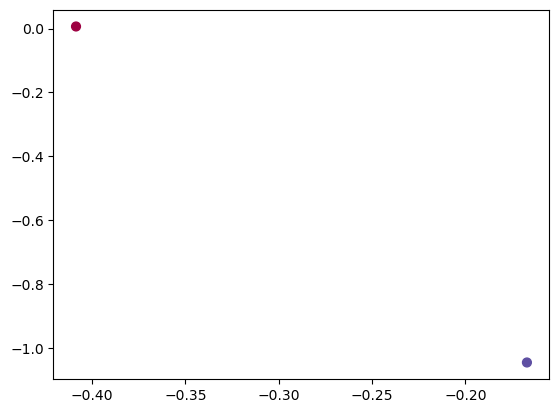

In [11]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
plt.show()

#### Logistic Regression

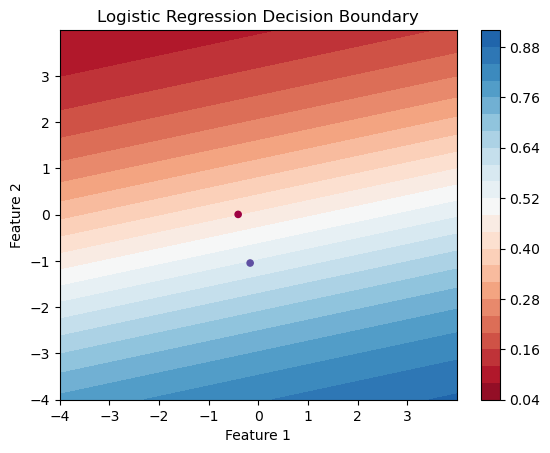

Accuracy of logistic regression: 100 % (percentage of correctly labelled datapoints)


In [12]:
import sklearn
from sklearn.linear_model import LogisticRegression

xx, yy = np.mgrid[-4:4:.01, -4:4:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
clf=LogisticRegression()

clf.fit(X.T, Y.ravel())

probs = clf.predict_proba(grid)[:, 1]
probs = probs.reshape(xx.shape)

plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
plt.colorbar()
plt.scatter(X[0, :], X[1, :], c=Y, s=20, cmap=plt.cm.Spectral)
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")


In [13]:
n_x = X.shape[0] # size of input layer`
n_h = 4
n_y = Y.shape[0] # size of output layer

print(n_x, n_y)

2 1


In [14]:
import numpy as np

W1 = np.random.randn(n_h,n_x) * 0.01 #4x2
b1 = np.zeros(shape=(n_h, 1)) #4x1
W2 = np.random.randn(n_y,n_h) * 0.01 #1x4
b2 = np.zeros(shape=(n_y, 1))#1x1

print("W1\n", W1)
print("b1\n", b1)
print("W2\n", W2)
print("b2\n", b2)

W1
 [[-0.0014547  -0.00125074]
 [ 0.00684161  0.00356426]
 [ 0.00406047 -0.00042689]
 [ 0.00070529  0.01353253]]
b1
 [[0.]
 [0.]
 [0.]
 [0.]]
W2
 [[ 0.01648919 -0.01214502 -0.00423423  0.0163539 ]]
b2
 [[0.]]


In [15]:
def sigmoid(x):
    return 1 / (1 + np.e ** -x)



In [16]:
# Set the learning rates
learning_rates = [0.0001, 0.01, 1]
graph_op = {}
delta_op = []

# Train the network for each learning rate
for learning_rate in learning_rates:
    print(f"Learning rate: {learning_rate}")
    total_cost = -9999
    delta_op = []
    for i in range(10):
        # Implement Forward Propagation to calculate A2 (probabilities)
        Z1 = np.dot(W1,X) + b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(W2,A1) + b2
        A2 = sigmoid(Z2) # Final output prediction
        
        # Compute the cross-entropy cost
        samples=2
        old_total_cost = total_cost
        cost_function = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2)) #J(theta)
        total_cost = -np.sum(cost_function) / samples
        
        
        dJdZ2 = A2 - Y
        dJdW2 = (1 / samples) * np.dot(dJdZ2, A1.T)
        dJdb2 = (1 / samples) * np.sum(dJdZ2, axis=1, keepdims=True)
        # since activation function is tanh(Z1) = A1
        # first derivative of d/dz tanh(z) = 1 - tanh(z) ^ 2 = 1 - A1 ^ 2
        dJdZ1 = np.multiply(np.dot(W2.T, dJdZ2), 1 - np.power(A1, 2))
        dJdW1 = (1 / samples) * np.dot(dJdZ1, X.T)
        dJdb1 = (1 / samples) * np.sum(dJdZ1, axis=1, keepdims=True)
        
        b2_old = b2
        print(f"\nIteration {i}: ")
        print("cost=", total_cost)
        print("cost delta=", np.subtract(total_cost, old_total_cost))
        print("b2 before=", b2_old[0][0])
        W1 = W1 - learning_rate * dJdW1
        b1 = b1 - learning_rate * dJdb1
        W2 = W2 - learning_rate * dJdW2
        b2 = b2 - learning_rate * dJdb2

        print("b2 after=", b2[0][0])
        delta = np.subtract(b2, b2_old)[0][0]
        print("delta change=", delta)
        delta_op.append(delta)
    graph_op[learning_rate] = delta_op    
    print("***********************************************")


Learning rate: 0.0001

Iteration 0: 
cost= 0.6931958223612041
cost delta= 9999.693195822361
b2 before= 0.0
b2 after= 1.2550198534910796e-09
delta change= 1.2550198534910796e-09

Iteration 1: 
cost= 0.6931958159576267
cost delta= -6.403577446079112e-09
b2 before= 1.2550198534910796e-09
b2 after= 2.509730356448081e-09
delta change= 1.2547105029570016e-09

Iteration 2: 
cost= 0.6931958095541908
cost delta= -6.403435892643472e-09
b2 before= 2.509730356448081e-09
b2 after= 3.7641315218550634e-09
delta change= 1.2544011654069822e-09

Iteration 3: 
cost= 0.6931958031508964
cost delta= -6.403294450230135e-09
b2 before= 3.7641315218550634e-09
b2 after= 5.018223362701635e-09
delta change= 1.2540918408465719e-09

Iteration 4: 
cost= 0.6931957967477435
cost delta= -6.403152896794495e-09
b2 before= 5.018223362701635e-09
b2 after= 6.272005891971855e-09
delta change= 1.2537825292702196e-09

Iteration 5: 
cost= 0.6931957903447319
cost delta= -6.40301156540346e-09
b2 before= 6.272005891971855e-09
b2 af

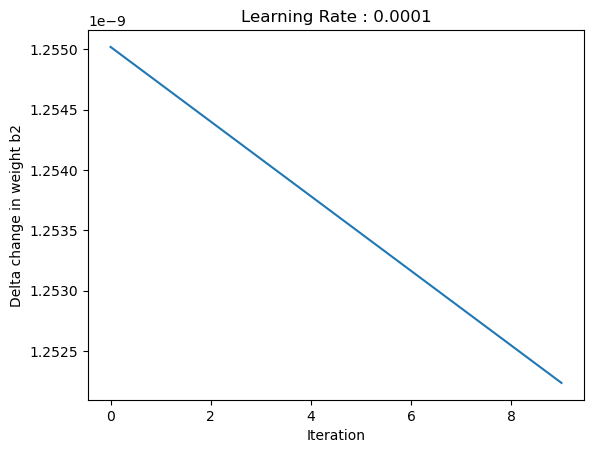

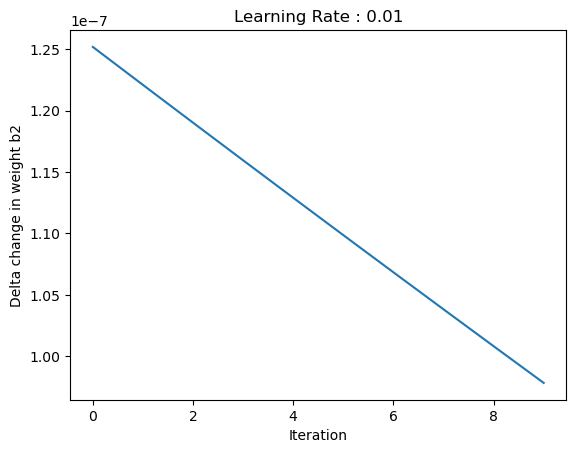

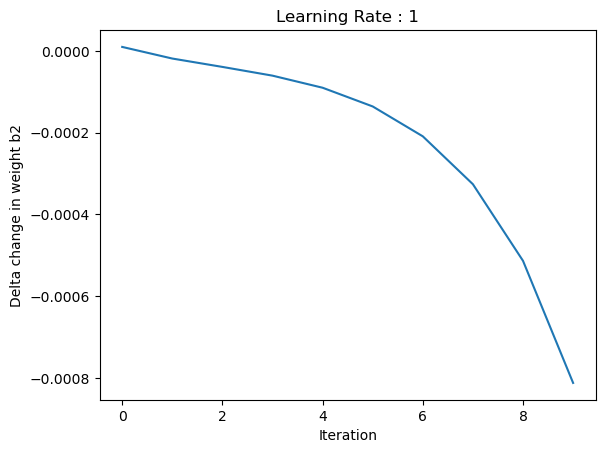

In [17]:
#plot and visualise the delta changes
for i in list(graph_op.keys()):
    # Create a list of iteration indices based on the length of the delta list
    iterations = list(range(len(graph_op[i])))

    # Plot the graph
    plt.plot(iterations, graph_op[i])

    # Set the x-label and y-label of the plot
    plt.xlabel('Iteration')
    plt.ylabel('Delta change in weight b2')
    plt.title('Learning Rate : '+ str(i))

    # Show the plot
    plt.show()


##### 2 What can you conclude about the effect of the learning rate on the delta change in weight b2?

Learning rate is a hyperparameter in machine learning that controls the step size at each iteration while moving toward a minimum of a loss function. In the above scenario, we have given three different learning rates: 0.0001, 0.01, and 1. For each learning rate, we are giving ten iterations, where we update a parameter b2 at each iteration.

* For the first <b>learning rate of 0.0001,</b> we see that the change in b2 at each iteration is very small, on the order of 1e-9. The cost decreases steadily, and the change in the cost between iterations is also small. This suggests that the step size is too small and that the algorithm may take a long time to converge to the minimum of the loss function. 

* For the second <b>learning rate of 0.01,</b> we see that the change in b2 at each iteration is much larger, on the order of 1e-7. The cost decreases very quickly, with large changes in the cost between iterations, but the algorithm seems to converge.

* For the third <b>learning rate of 1,</b> we see that the change in b2 at each iteration is very large, on the order of 1e-5. This suggests that the step size is much too large and that the algorithm is overshooting the optimal point and diverges rather than converge to the minimum of the loss function.

Therefore, a larger learning rate allows the algorithm to take larger steps towards the minimum cost, which can result in faster convergence. However, if the learning rate is too large, the algorithm can overshoot the minimum and diverge. In this case, <b>the learning rate of 0.01 seems to be a good choice,</b> as it results in a faster decrease in the cost while avoiding divergence.